# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense
# from keras import regularizers
import pydot
from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# Functions

In [2]:
def grid_search_classifier(function, param_grid, cv = 4):
    # Running Grid Search
    grid_search = GridSearchCV(function, param_grid, cv = cv)
    grid_search.fit(x_train, y_train)
    
    # Outputting results
    print(f'Best parameters are: {grid_search.best_params_}\n')
    print(f'Accuracy is: {grid_search.score(x_test, y_test)}\n')
    try:
        print(f'AUC score is: {roc_auc_score(y_test, grid_search.predict_proba(x_test)[:, 1])}\n')
    except:
        pass
    best_model = grid_search.best_estimator_
    pred_rf = best_model.predict(x_test)
    print(f'Classification report:\n {classification_report(y_test, pred_rf, target_names = ["Lower Ranked", "Higher Ranked"])}')
    
    return best_model

# Data work

In [3]:
data = pd.read_csv('mma_data.csv', index_col=0)

# Filtering out unwanted rows
data = data[data.result >= 0]
data = data[data.slpm_2 + data.sapm_2 != 0]
data = data[data.slpm_1 + data.sapm_1 != 0]

In [4]:
# Engineering some columns
data['reach_diff'] = data.reach_1 - data.reach_2
data['age_diff'] = data.age_1 - data.age_2
data['slpm_diff'] = data.slpm_1 - data.slpm_2
data['sapm_diff'] = data.sapm_1 - data.sapm_2
data['td_acc_diff'] = data.td_acc_1 - data.td_acc_2
data['td_def_diff'] = data.td_def_1 - data.td_def_2
data['td_avg_diff'] = data.td_avg_1 - data.td_avg_2
data['sub_avg_diff'] = data.sub_avg_1 - data.sub_avg_2
data['strk_acc_diff'] = data.strk_acc_1 - data.strk_acc_2
data['strk_def_diff'] = data.strk_def_1 - data.strk_def_2
data['wins_diff'] = data.wins_1 - data.wins_2
data['losses_diff'] = data.losses_1 - data.losses_2
data['win_pct_1'] = data.wins_1/(data.losses_1 + data.wins_1)
data['win_pct_2'] = data.wins_2/(data.losses_2 + data.wins_2)
data['win_pct_diff'] = data.win_pct_1 - data.win_pct_2

# Droping unecessary columnns and scaling data
data.drop(['fighter_1', 'fighter_2'], axis = 1, inplace = True)
x_cols = ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1']
y_col = ['result']
x, y = data[x_cols], data[y_col]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Formatting data
x_train = x_train.values
y_train = y_train.values.ravel()
x_test = x_test.values
y_test = y_test.values.ravel()

# Predicting Winner

### Setting Baseline

In [35]:
print(f'Predicting fighter 1 would yield {data.result.mean()*100}% accuracy')

df = data.copy()
df['Higher_Pct'] = df.win_pct_diff.apply(lambda x: 1 if x > 0 else 0)
df['Result_Tracker'] = df.apply(lambda x: 1 if (x.Higher_Pct == 1) & (x.result == 1)
                               else 1 if (x.Higher_Pct == 0) & (x.result == 0)
                               else 0, axis = 1)
print(f'Predicting the fighter with the higher win percentage would yield {df.Result_Tracker.mean()*100}% accuracy')

Predicting fighter 1 would yield 57.57575757575758% accuracy
Predicting the fighter with the higher win percentage would yield 56.060606060606055% accuracy


### Neural Network

In [6]:
# Scaling data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Instantiating NN model
model = Sequential()
model.add(Dense(16, input_dim=x_train_scaled.shape[1],
                activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [7]:
model.fit(x=x_train_scaled, y=y_train, epochs=200, batch_size=64, verbose=0)
test_results = model.evaluate(x = x_test_scaled, y = y_test, verbose=0)
print("Test Accuracy = {}".format(test_results[1]))

Test Accuracy = 0.5487805008888245


### Random Forest

In [18]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
rf = grid_search_classifier(RandomForestClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 4, 'max_features': 8, 'n_estimators': 15}

Accuracy is: 0.6021505376344086

AUC score is: 0.6666666666666666

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.72      0.38      0.49        48
Higher Ranked       0.56      0.84      0.67        45

     accuracy                           0.60        93
    macro avg       0.64      0.61      0.58        93
 weighted avg       0.64      0.60      0.58        93



### Gradient Boost

In [37]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
gb = grid_search_classifier(GradientBoostingClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 5, 'max_features': 5, 'n_estimators': 5}

Accuracy is: 0.5591397849462365

AUC score is: 0.5752314814814814

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.77      0.21      0.33        48
Higher Ranked       0.53      0.93      0.67        45

     accuracy                           0.56        93
    macro avg       0.65      0.57      0.50        93
 weighted avg       0.65      0.56      0.49        93



### Logistic Regression

In [5]:
# Creating parameter grid

c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c
}

# Running ML function
lr = grid_search_classifier(LogisticRegression(random_state = 0, max_iter = 500), param_grid)

/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

Best parameters are: {'C': 100}

Accuracy is: 0.5806451612903226

AUC score is: 0.648611111111111

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.70      0.33      0.45        48
Higher Ranked       0.54      0.84      0.66        45

     accuracy                           0.58        93
    macro avg       0.62      0.59      0.56        93
 weighted avg       0.62      0.58      0.55        93



/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

### SVM

In [39]:
# Creating parameter grid

kernel = ['rbf', 'poly', 'sigmoid']
degree = [int(x) for x in np.linspace(start = 2, stop = 7, num = 5)]
c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c,
    'kernel' : kernel,
    'degree' : degree
}

# Running ML function
svm = grid_search_classifier(SVC(random_state = 0), param_grid)

Best parameters are: {'C': 100, 'degree': 2, 'kernel': 'poly'}

Accuracy is: 0.6344086021505376

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.89      0.33      0.48        48
Higher Ranked       0.57      0.96      0.72        45

     accuracy                           0.63        93
    macro avg       0.73      0.64      0.60        93
 weighted avg       0.74      0.63      0.60        93



### Naive Bayes

In [ ]:
# Creating parameter grid

var_smoothing = [int(1**x) for x in np.linspace(start = -9, stop = 0, num = 10)]
param_grid = {
    'var_smoothing' : var_smoothing
}

# Running ML function
grid_search_classifier(GaussianNB(random_state = 0), param_grid)

### Ensemble

In [31]:
x = x.values

# Iterating over models to create prediction columns
models = [rf, gb, lr, svm]
names = ['rf', 'gb', 'lr', 'svm']
for model, name in zip(models, names):
    try:
        data[f'{name}_pred'] = model.predict_proba(x)
    except:
        data[f'{name}_pred'] = model.predict(x)

# Re-formatting data
x_ensemble, y_ensemble = data[x_cols], data[y_col]
x_train_ensemble, x_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(x_ensemble, y_ensemble, test_size = 0.2, random_state = 0)

x_train_ensemble = x_train_ensemble.values
y_train_ensemble = y_train_ensemble.values.ravel()
x_test_ensemble = x_test_ensemble.values
y_test_ensemble = y_test_ensemble.values.ravel()

# Creating parameter grid
c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c
}

# Running Logistic

# Running Grid Search
grid_search = GridSearchCV(LogisticRegression(random_state = 0, max_iter = 500), param_grid, cv = 4)
grid_search.fit(x_train_ensemble, y_train_ensemble)

# Outputting results
print(f'Best parameters are: {grid_search.best_params_}\n')
print(f'Accuracy is: {grid_search.score(x_test_ensemble, y_test_ensemble)}\n')
try:
    print(f'AUC score is: {roc_auc_score(y_test_ensemble, grid_search.predict_proba(x_test)[:, 1])}\n')
except:
    pass
ensemble = grid_search.best_estimator_
pred_rf = ensemble.predict(x_test_ensemble)
print(f'Classification report:\n {classification_report(y_test_ensemble, pred_rf, target_names = ["Lower Ranked", "Higher Ranked"])}')
    

Best parameters are: {'C': 0.01}

Accuracy is: 0.6103896103896104

AUC score is: 0.6336088154269972

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.57      0.36      0.44        33
Higher Ranked       0.62      0.80      0.70        44

     accuracy                           0.61        77
    macro avg       0.60      0.58      0.57        77
 weighted avg       0.60      0.61      0.59        77



# Predicting KO

In [43]:
y = data['KO_OVR']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Formatting data
x_train = x_train.values
y_train = y_train.values.ravel()
x_test = x_test.values
y_test = y_test.values.ravel()

### Setting Baseline

In [41]:
print(f'Always predicting no knockout would yield {100 - data.KO_OVR.mean()*100}% accuracy')

df = data.copy()
df['Higher_Pct'] = df.slpm_1.apply(lambda x: 1 if x > 0 else 0)
df['Result_Tracker'] = df.apply(lambda x: 1 if (x.Higher_Pct == 1) & (x.result == 1)
                               else 1 if (x.Higher_Pct == 0) & (x.result == 0)
                               else 0, axis = 1)
print(f'Predicting the fighter with the higher SLPM would yield {df.Result_Tracker.mean()*100}% accuracy')

Always predicting no knockout would yield 62.836185819070906% accuracy
Predicting the fighter with the higher SLPM would yield 57.21271393643031% accuracy


### Random Forest

In [44]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
rf = grid_search_classifier(RandomForestClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 6, 'max_features': 8, 'n_estimators': 15}

Accuracy is: 0.524390243902439

AUC score is: 0.4155844155844156

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.58      0.76      0.65        49
Higher Ranked       0.33      0.18      0.24        33

     accuracy                           0.52        82
    macro avg       0.46      0.47      0.45        82
 weighted avg       0.48      0.52      0.49        82



### Gradient Boost

In [45]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
gb = grid_search_classifier(GradientBoostingClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 10, 'max_features': 10, 'n_estimators': 6}

Accuracy is: 0.5121951219512195

AUC score is: 0.4001236858379716

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.57      0.76      0.65        49
Higher Ranked       0.29      0.15      0.20        33

     accuracy                           0.51        82
    macro avg       0.43      0.45      0.42        82
 weighted avg       0.46      0.51      0.47        82



### Logistic Regression

In [46]:
# Creating parameter grid

c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c
}

# Running ML function
lr = grid_search_classifier(LogisticRegression(random_state = 0, max_iter = 500), param_grid)

/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

Best parameters are: {'C': 0.1}

Accuracy is: 0.5487804878048781

AUC score is: 0.45701917130488556

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.59      0.80      0.68        49
Higher Ranked       0.38      0.18      0.24        33

     accuracy                           0.55        82
    macro avg       0.48      0.49      0.46        82
 weighted avg       0.50      0.55      0.50        82



/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

### SVM

In [47]:
# Creating parameter grid

kernel = ['rbf', 'poly', 'sigmoid']
degree = [int(x) for x in np.linspace(start = 2, stop = 7, num = 5)]
c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c,
    'kernel' : kernel,
    'degree' : degree
}

# Running ML function
svm = grid_search_classifier(SVC(random_state = 0), param_grid)

Best parameters are: {'C': 10, 'degree': 5, 'kernel': 'poly'}

Accuracy is: 0.5609756097560976

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.59      0.84      0.69        49
Higher Ranked       0.38      0.15      0.22        33

     accuracy                           0.56        82
    macro avg       0.49      0.49      0.46        82
 weighted avg       0.51      0.56      0.50        82



# Predicting SUB

### Setting Up Data

In [5]:
# Unsampling data to get a higher % of submissions

sub_data = data[data.SUB_OVR == 1]
non_sub_data = data[data.SUB_OVR == 0].sample(sub_data.shape[0])
data_sub = pd.concat([sub_data, non_sub_data])

# Splitting data for training
y_col = ['SUB_OVR']
x, y = data_sub[x_cols], data_sub[y_col]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Formatting data
x_train = x_train.values
y_train = y_train.values.ravel()
x_test = x_test.values
y_test = y_test.values.ravel()

### Setting Baseline

In [7]:
print(f'Always predicting no sub would yield {100 - data.SUB_OVR.mean()*100}% accuracy')

Always predicting no sub would yield 80.73593073593074% accuracy


### Random Forest

In [8]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
rf = grid_search_classifier(RandomForestClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 6, 'max_features': 4, 'n_estimators': 13}

Accuracy is: 0.5

AUC score is: 0.40625

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.46      0.75      0.57        16
Higher Ranked       0.60      0.30      0.40        20

     accuracy                           0.50        36
    macro avg       0.53      0.53      0.49        36
 weighted avg       0.54      0.50      0.48        36



### Gradient Boost

In [9]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
gb = grid_search_classifier(GradientBoostingClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 2, 'max_features': 3, 'n_estimators': 4}

Accuracy is: 0.4444444444444444

AUC score is: 0.45625

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.42      0.69      0.52        16
Higher Ranked       0.50      0.25      0.33        20

     accuracy                           0.44        36
    macro avg       0.46      0.47      0.43        36
 weighted avg       0.47      0.44      0.42        36



### Logistic Regression

In [10]:
# Creating parameter grid

c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c
}

# Running ML function
lr = grid_search_classifier(LogisticRegression(random_state = 0, max_iter = 500), param_grid)

/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

Best parameters are: {'C': 10}

Accuracy is: 0.4166666666666667

AUC score is: 0.409375

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.38      0.50      0.43        16
Higher Ranked       0.47      0.35      0.40        20

     accuracy                           0.42        36
    macro avg       0.42      0.42      0.42        36
 weighted avg       0.43      0.42      0.41        36



/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

### SVM

In [11]:
# Creating parameter grid

kernel = ['rbf', 'poly', 'sigmoid']
degree = [int(x) for x in np.linspace(start = 2, stop = 7, num = 5)]
c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c,
    'kernel' : kernel,
    'degree' : degree
}

# Running ML function
svm = grid_search_classifier(SVC(random_state = 0), param_grid)

Best parameters are: {'C': 10, 'degree': 5, 'kernel': 'poly'}

Accuracy is: 0.5833333333333334

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.54      0.44      0.48        16
Higher Ranked       0.61      0.70      0.65        20

     accuracy                           0.58        36
    macro avg       0.57      0.57      0.57        36
 weighted avg       0.58      0.58      0.58        36



# PCA 

In [26]:
# Scaling data
data_scaled = pd.DataFrame(StandardScaler().fit_transform(data), columns = data.columns, index = data.index)

# Fitting PCA
pca = PCA().fit(data_scaled)

# Definining and executing function to get weights
def PC_Weights():
    weights = pd.DataFrame()
    
    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
        
    weights = weights.values.T
    return weights

weights = PC_Weights()

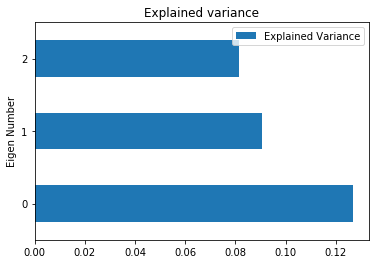

In [33]:
# Explained variance

data_dict = {
    'Explained Variance' : list(pca.explained_variance_ratio_[:3]),
    'Eigen Number' : list(range(3))
}
df = pd.DataFrame(data_dict)
df.plot.barh(title = "Explained variance", x = 'Eigen Number', y = 'Explained Variance')

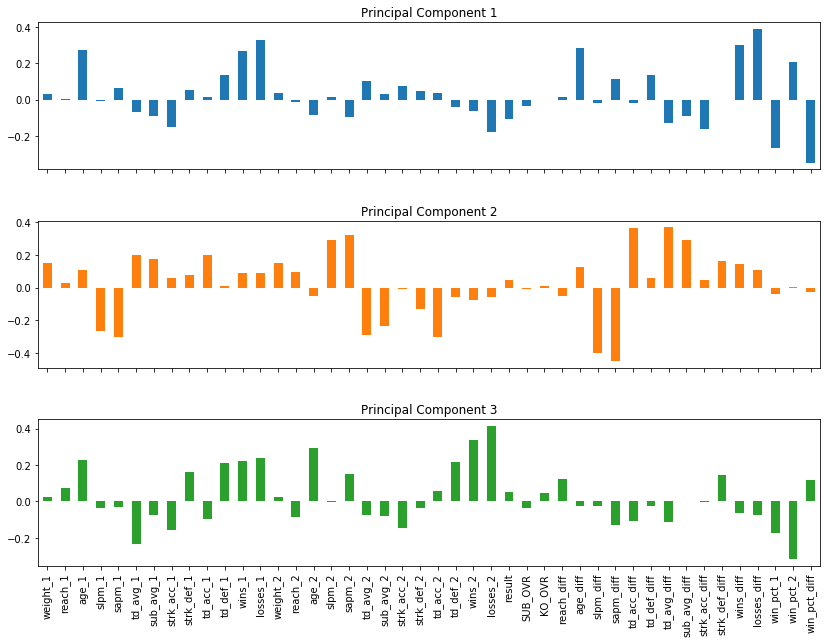

In [25]:
# Graphing top Eigenvectors
Num_Comps = 3
top_eigens = pd.DataFrame(weights[:Num_Comps], columns = data_scaled.columns)
top_eigens.index = [f'Principal Component {i}' for i in range(1, Num_Comps + 1)]

axes = top_eigens.T.plot.bar(subplots = True, legend = False, figsize = (14, 10))
plt.subplots_adjust(hspace = 0.35)

# Testing

### Data setup

In [22]:
# Importing
data = pd.read_csv('mma_data_odds.csv', index_col = 0)

# Engineering some columns
data['reach_diff'] = data.reach_1 - data.reach_2
data['age_diff'] = data.age_1 - data.age_2
data['slpm_diff'] = data.slpm_1 - data.slpm_2
data['sapm_diff'] = data.sapm_1 - data.sapm_2
data['td_acc_diff'] = data.td_acc_1 - data.td_acc_2
data['td_def_diff'] = data.td_def_1 - data.td_def_2
data['td_avg_diff'] = data.td_avg_1 - data.td_avg_2
data['sub_avg_diff'] = data.sub_avg_1 - data.sub_avg_2
data['strk_acc_diff'] = data.strk_acc_1 - data.strk_acc_2
data['strk_def_diff'] = data.strk_def_1 - data.strk_def_2
data['wins_diff'] = data.wins_1 - data.wins_2
data['losses_diff'] = data.losses_1 - data.losses_2
data['win_pct_1'] = data.wins_1/(data.losses_1 + data.wins_1)
data['win_pct_2'] = data.wins_2/(data.losses_2 + data.wins_2)
data['win_pct_diff'] = data.win_pct_1 - data.win_pct_2

# Droping unecessary columnns and scaling data
x_cols = ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1']
x_predict = data[x_cols]

# Formatting data
x_predict = x_predict.values

# Putting model predictions into the data

data['Prediction_1_lr'] = lr.predict_proba(x_predict)[:, 0]
data['Prediction_2_lr'] = 1.0 - data.Prediction_1_lr
data['Prediction_rf'] = rf.predict(x_predict)

### Random Forest Testing

In [46]:
# Function to create bet size
def rf_bets(row):
    if row.Prediction_rf == 1:
        if (row.Fighter_1_Odds > 100) & (row.Fighter_1_Odds < 150):
            bet = 100
        elif (row.Fighter_1_Odds >= 150) & (row.Fighter_1_Odds < 200):
            bet = 250
        elif (row.Fighter_1_Odds >= 200):
            bet = 500
        elif (row.Fighter_1_Odds <= 100) & (row.Fighter_1_Odds > -150):
            bet = 75
        elif (row.Fighter_1_Odds <= -150) & (row.Fighter_1_Odds > -200):
            bet = 50
        elif (row.Fighter_1_Odds <= -200):
            bet = 25
        else:
            bet = 0
    if row.Prediction_rf == 0:
        if (row.Fighter_2_Odds > 100) & (row.Fighter_2_Odds < 150):
            bet = 100
        elif (row.Fighter_2_Odds >= 150) & (row.Fighter_2_Odds < 200):
            bet = 250
        elif (row.Fighter_2_Odds >= 200):
            bet = 500
        elif (row.Fighter_2_Odds <= 100) & (row.Fighter_2_Odds > -150):
            bet = 75
        elif (row.Fighter_2_Odds <= -150) & (row.Fighter_2_Odds > -200):
            bet = 50
        elif (row.Fighter_2_Odds <= -200):
            bet = 25
        else:
            bet = 0
    return bet

def calculate_payoff_and_result(row):
    # Calculating Payoff
    if row.Prediction_rf == 1:
        if row.Fighter_1_Odds>0:
            payoff = (row.Fighter_1_Odds/100)*row.Bet
        else:
            payoff = row.Bet/((abs(row.Fighter_1_Odds)/100))
    else:
        if row.Fighter_2_Odds>0:
            payoff = (row.Fighter_2_Odds/100)*row.Bet
        else:
            payoff = row.Bet/((abs(row.Fighter_2_Odds)/100))
    # Calculating Bet Result
    if row.Prediction_rf == row.result:
        bet_result = payoff
    else:
        bet_result = -(row.Bet)
    
    return bet_result
            
data_rf = data[['fighter_1', 'fighter_2', 'Fighter_1_Odds', 'Fighter_2_Odds', 'Prediction_rf', 'result']].reset_index(drop = True)
data_rf['Bet'] = data_rf.apply(rf_bets, axis = 1)
data_rf['Bet_Result'] = data_rf.apply(calculate_payoff_and_result, axis = 1)

data_rf.Bet_Result.sum()

21595.289520879956

In [52]:
data_rf[200:250]

fighter_1            fighter_2  Fighter_1_Odds  Fighter_2_Odds  \
200        SergheiSpivac            GregHardy          -205.0           142.0   
201          JalinTurner       JamieMullarkey          -161.0           120.0   
202        BrianKelleher     UmarNurmagomedov           560.0         -1500.0   
203         DevonteSmith         LudovitKlein          -161.0           116.0   
204         DustinJacoby   MichalOleksiejczuk          -222.0           152.0   
205         ThiagoSantos      MagomedAnkalaev           400.0          -800.0   
206         MarlonMoraes           SongYadong           220.0          -310.0   
207          SodiqYusuff          AlexCaceres          -303.0           195.0   
208            DrewDober     TerranceMcKinney          -170.0           120.0   
209          AlexPereira           BrunoSilva          -225.0           155.0   
210  MatthewSemelsberger           AJFletcher          -200.0           145.0   
211          TrevinJones        JavidBasharat           122.0          -190.0   
212         DamonJackson          KamuelaKirk          -140.0          -111.0   
213    DalchaLungiambula         CodyBrundage          -150.0           100.0   
214         KrisMoutinho        GuidoCannetti          -184.0           120.0   
215         TafonNchukwi     AzamatMurzakanov           145.0          -227.0   
216      AlexanderVolkov          TomAspinall           100.0          -152.0   
217          ArnoldAllen            DanHooker          -121.0          -115.0   
218        PaddyPimblett         KazulaVargas             NaN             NaN   
219         GunnarNelson          TakashiSato          -800.0           360.0   
220           JaiHerbert          IliaTopuria           400.0          -650.0   
221           MikeGrundy      MakwanAmirkhani          -305.0           170.0   
222   ShamilAbdurakhimov      SergeiPavlovich           250.0          -400.0   
223         NikitaKrylov            PaulCraig          -210.0           155.0   
224            JackShore          TimurValiev          -140.0          -111.0   
225       MuhammadMokaev           CodyDurden          -600.0           350.0   
226        CurtisBlaydes         ChrisDaukaus          -600.0           333.0   
227            MattBrown       BryanBarberena          -110.0          -125.0   
228         AskarAskarov       KaiKara-France          -455.0           290.0   
229         MarcDiakiese  ViacheslavBorshchev           115.0          -158.0   
230            NeilMagny           MaxGriffin          -300.0           210.0   
231       ChrisGutierrez        BatgerelDanaa           110.0          -155.0   
232    AliaskhabKhizriev       DenisTiuliulin         -1400.0           575.0   
233       MatheusNicolau          DavidDvorak           100.0          -140.0   
234          LuisSaldana           BrunoSouza           110.0          -159.0   
235         VicenteLuque        BelalMuhammad          -200.0           140.0   
236         CaioBorralho   GadzhiOmargadzhiev          -105.0          -139.0   
237          MiguelBaeza          AndreFialho          -189.0           135.0   
238          PatSabatini            TJLaramie          -750.0           335.0   
239         MounirLazzez            AngeLoosa         -5000.0           155.0   
240           DevinClark        WilliamKnight          -190.0           137.0   
241         DrakkarKlose       BrandonJenkins          -800.0           400.0   
242           RafaGarcia          JesseRonson           100.0          -160.0   
243         ChrisBarnett          MartinBuday           240.0          -300.0   
244        JordanLeavitt            TreyOgden           110.0          -148.0   
245            ClayGuida       ClaudioPuelles          -113.0          -125.0   
246         LandoVannata      CharlesJourdain          -110.0          -139.0   
247         JordanWright  Marc-AndreBarriault           150.0          -220.0   
248          DwightGrant     SergeyKhandozhko 

In [31]:
data.columns

Index(['fighter_1', 'weight_1', 'reach_1', 'age_1', 'slpm_1', 'sapm_1',
       'td_avg_1', 'sub_avg_1', 'strk_acc_1', 'strk_def_1', 'td_acc_1',
       'td_def_1', 'wins_1', 'losses_1', 'fighter_2', 'weight_2', 'reach_2',
       'age_2', 'slpm_2', 'sapm_2', 'td_avg_2', 'sub_avg_2', 'strk_acc_2',
       'strk_def_2', 'td_acc_2', 'td_def_2', 'wins_2', 'losses_2', 'result',
       'SUB_OVR', 'KO_OVR', 'Fighter_1_Odds', 'Fighter_2_Odds', 'reach_diff',
       'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
       'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff',
       'wins_diff', 'losses_diff', 'win_pct_1', 'win_pct_2', 'win_pct_diff',
       'Prediction_1_lr', 'Prediction_2_lr', 'Prediction_rf'],
      dtype='object')